In [1]:
# silencing some logs/warning
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
%env WANDB_SILENT=True

import os
import sys
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import wandb

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from process_data import process_data
from evaluate import evaluate_pred, print_dummy_evaluations
from visualization import plot_confusion_matrix
from utils.constants import SEED

env: WANDB_SILENT=True


In [2]:
wandb.login()

True

# Get data

In [3]:
split_prec = {
    'train': 0.7, 
    'valid': 0.15, 
    'test': 0.15
}
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = process_data(split_prec, scaler)

## Oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
#sampler = RandomOverSampler(random_state=SEED)
sampler = SMOTE(sampling_strategy=0.4, random_state=SEED)
print('Label numbers: ', Y_train.value_counts())
X_train, Y_train = sampler.fit_resample(X_train, Y_train)
print('Label numbers, after resample: ', Y_train.value_counts())

columns = X_train.columns.to_list()

Dropped columns: ['day_of_week' 'month' 'snow']
New columns: ['autumn' 'bad_weather' 'cold' 'day_0' 'day_1' 'day_2' 'day_3' 'day_4'
 'day_5' 'day_6' 'month_1' 'month_10' 'month_11' 'month_12' 'month_2'
 'month_3' 'month_4' 'month_5' 'month_6' 'month_7' 'month_8' 'month_9'
 'night' 'rain' 'spring' 'temp_fahrenheit' 'winter']
Split: "train" 	[Size: 1120] 	[Prec: 0.7]
	X: (1120, 39)
	Y: (1120,)
Split: "valid" 	[Size: 239] 	[Prec: 0.149375]
	X: (239, 39)
	Y: (239,)
Split: "test" 	[Size: 241] 	[Prec: 0.150625]
	X: (241, 39)
	Y: (241,)
Label numbers:  increase_stock
0    913
1    207
Name: count, dtype: int64
Label numbers, after resample:  increase_stock
0    913
1    365
Name: count, dtype: int64


# Hyperparameter Optimization
1. Set up configuration (possible values)
2. Run optimization
3. Get best parameters

In [4]:
## 1. Set up configuration

PROJECT_NAME = 'SML'
PROJECT_ENTITY = 'daniel-veress'

GOAL_METRIC = 'accuracy'
NUMBER_OF_RUNS = 90
sweep_configuration = {
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': GOAL_METRIC},
    'parameters': {
        'loss': {'values': ['log_loss', 'exponential']},
        'learning_rate': {'max': 0.5, 'min': 0.01},
        'n_estimators': {'max':150, 'min': 5},
        'criterion': {'values': ['friedman_mse', 'squared_error']},
        'min_samples_split': {'max': 8, 'min': 2},
        'max_depth': {'max': 100, 'min': 1},
        'max_features': {'values': ['sqrt', 'log2', None]}
    }
}

sweep_id = wandb.sweep(
    project=PROJECT_NAME,
    sweep=sweep_configuration
)

Create sweep with ID: i2oexrhc
Sweep URL: https://wandb.ai/daniel-veress/SML/sweeps/i2oexrhc


In [5]:
## 2. Run optimization

def objective(config):
    # creating the model
    model = GradientBoostingClassifier(
        loss=config.loss,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        criterion=config.criterion,
        min_samples_split=config.min_samples_split,
        max_depth=config.max_depth,
        max_features=config.max_features,
        random_state=SEED
    )

    # training
    model.fit(X_train, Y_train)
    
    # evaluating
    y_pred = model.predict(X_valid)
    y_true = Y_valid
    metrics = evaluate_pred(y_pred, y_true)
    return metrics

def main():
    run = wandb.init(
      project=PROJECT_NAME,
      config={
          'splits': split_prec,
          'scaler': scaler,
          'columns': columns
      }
    )
    metrics = objective(wandb.config)
    wandb.log(metrics)


# start sweeping/optimization
wandb.agent(sweep_id, function=main, count=NUMBER_OF_RUNS)
wandb.finish()

In [6]:
## 3. Get best parameters/run
api = wandb.Api()
sweep = api.sweep(f'{PROJECT_ENTITY}/{PROJECT_NAME}/sweeps/{sweep_id}')
best_run = sweep.best_run(order=GOAL_METRIC)

print('Best hyperparameters:')
best_parameters = best_run.config
non_model_parameters = ['scaler', 'splits', 'columns']
hyperparameters = {}
for param, value in best_parameters.items():
    print(f'{param}: {value}')
    # correct parameters, so only model hyperparameters are included
    if param not in non_model_parameters:
        hyperparameters[param] = value

print('\nMetrics:')
best_metrics = best_run.summary
for param, value in best_metrics.items():
    if '_' != param[0]:
        print(f'{param:<10}: {value}')

Best hyperparameters:
loss: exponential
scaler: MinMaxScaler()
splits: {'test': 0.15, 'train': 0.7, 'valid': 0.15}
columns: ['hour_of_day', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'night', 'winter', 'spring', 'autumn', 'cold', 'rain', 'bad_weather', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_fahrenheit']
criterion: squared_error
max_depth: 17
max_features: sqrt
n_estimators: 33
learning_rate: 0.290581736337793
min_samples_split: 5

Metrics:
accuracy  : 0.9163179916317992
precision : 0.8378378378378378
recall    : 0.6888888888888889


# Training

In [21]:
import pandas as pd
X_t = pd.concat([X_train, X_valid])
Y_t = pd.concat([Y_train, Y_valid])
X_t.shape

(1517, 39)

In [22]:
model = GradientBoostingClassifier(**hyperparameters, random_state=SEED)
model.fit(X_t, Y_t)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.290581736337793, loss='exponential',
                           max_depth=17, max_features='sqrt',
                           min_samples_split=5, n_estimators=33,
                           random_state=1)

# Evaluating

In [23]:
y_pred = model.predict(X_test)
y_true = Y_test

metrics = evaluate_pred(y_pred, y_true)

print('-- Boosting model --\n')
for metric, value in metrics.items():
    print(f'{metric.capitalize()}: \t{value}')

print('\n-- Dummy models -- ')
print_dummy_evaluations(X_train, Y_train, X_test, Y_test)

-- Boosting model --

Accuracy: 	0.8921161825726142
Recall: 	0.6388888888888888
Precision: 	0.6388888888888888

-- Dummy models -- 

Most_frequent
  Accuracy: 	0.8506224066390041
  Recall: 	0.0
  Precision: 	0.0

Stratified
  Accuracy: 	0.6348547717842323
  Recall: 	0.25
  Precision: 	0.12857142857142856

Uniform
  Accuracy: 	0.4315352697095436
  Recall: 	0.3333333333333333
  Precision: 	0.096


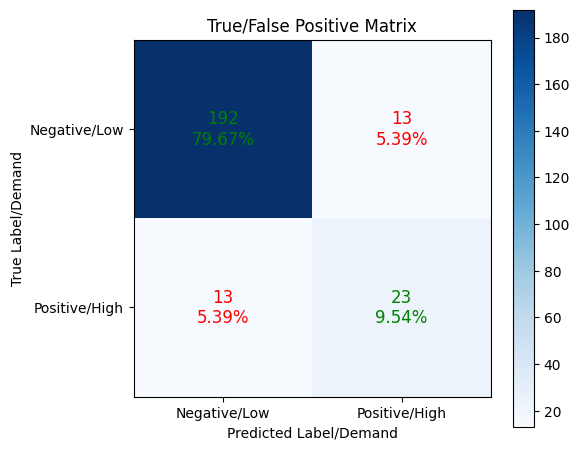

True Positive (TP): 23
True Negative (TN): 192
False Positive (FP): 13
False Negative (FN): 13


In [24]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
confusion_matrix_data = np.array([[tn, fp], [fn, tp]])
plot_confusion_matrix(confusion_matrix_data)

print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')